In [37]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [109]:
# Parámetros de la simulación
TIEMPO_SIMULACION = 100
TASA_LLEGADAS = 1/5      # una llegada cada 5 unidades de tiempo
TASA_SERVICIO = 1/4      # el servidor atiende en promedio cada 4 unidades de tiempo
NUM_SERVIDORES = 1       # Número de servidores (K en M/M/K/K)

# Arrays de tiempos de llegada y servicio
tiempos_llegada = [1,2,3,7,2,3,8,0,5] # Tiempos entre llegadas
tiempos_servicio = [9,1,4,1,1,5,3,8,2]  # Tiempos de servicio

# Variables para análisis
tiempos_espera = []
clientes_bloqueados = 0
total_clientes = 0

In [110]:
def cliente(env, nombre, servidor, tiempo_servicio):
    global clientes_bloqueados, total_clientes
    llegada = env.now
    total_clientes += 1
    # print(f"{nombre} llega en el tiempo {llegada:.2f}")
    
    # Verificar si hay capacidad en el servidor
    if servidor.count < servidor.capacity:
        with servidor.request() as req:
            yield req
            espera = env.now - llegada
            tiempos_espera.append(espera)
            # print(f"{nombre} empieza a ser atendido en {env.now:.2f} (esperó {espera:.2f})")
            
            #tiempo_servicio = random.expovariate(TASA_SERVICIO)
            yield env.timeout(tiempo_servicio)
            # print(f"{nombre} termina en {env.now:.2f}")
    else:
        clientes_bloqueados += 1
        # print(f"{nombre} es bloqueado en el tiempo {llegada:.2f} (servidor lleno)")

In [111]:
#def generador_clientes(env, servidor):
#    i = 0
#    while True:
#        yield env.timeout(random.expovariate(TASA_LLEGADAS))
#        i += 1
#        env.process(cliente(env, f"Cliente {i}", servidor))
def generador_clientes(env, servidor, tiempos_llegada, tiempos_servicio):
    i = 0
    for tiempo_llegada, tiempo_servicio in zip(tiempos_llegada, tiempos_servicio):
        yield env.timeout(tiempo_llegada)
        i += 1
        env.process(cliente(env, f"Cliente {i}", servidor, tiempo_servicio))

In [112]:

def bloqueo_erlang_b(K, l, m): 
    """Modelo Erlang B para M/M/K/K"""
    A= l / m
    B = 1.0
    for k in range(1, K + 1):
        B = (A * B) / (k + A * B)
    return B

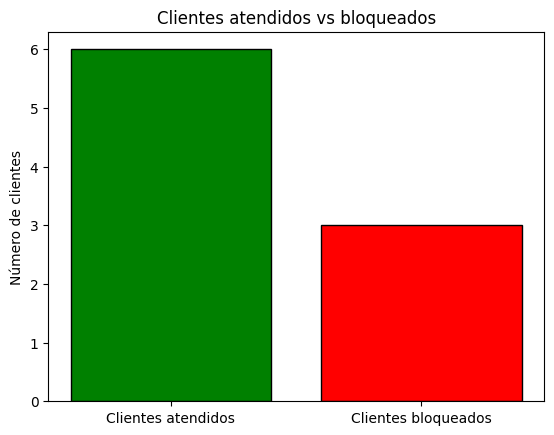


Clientes atendidos: 6
Clientes bloqueados: 3
Probabilidad de bloqueo: 0.33
Tasa de llegada (λ): 2.00
Tasa de servicio (μ): 0.26
Tráfico ofrecido: 7.56 Erlangs
Probabilidad de bloqueo (rechazo): 0.8831
Probabilidad de servicio exitoso: 0.1169


In [117]:
total_clientes = 0
clientes_bloqueados = 0

# Crear entorno de simulación
env = simpy.Environment()
servidor = simpy.Resource(env, capacity=NUM_SERVIDORES)# k servidores 
#env.process(generador_clientes(env, servidor))
env.process(generador_clientes(env, servidor, tiempos_llegada, tiempos_servicio))
env.run(until=TIEMPO_SIMULACION)

# Calcular probabilidad de bloqueo
probabilidad_bloqueo = clientes_bloqueados / total_clientes


# Representar visualmente la probabilidad de bloqueo
plt.bar(['Clientes atendidos', 'Clientes bloqueados'], 
        [total_clientes - clientes_bloqueados, clientes_bloqueados], 
        color=['green', 'red'], edgecolor='black')
plt.title("Clientes atendidos vs bloqueados")
plt.ylabel("Número de clientes")
plt.show()


# Estadísticas
print(f"\nClientes atendidos: {total_clientes - clientes_bloqueados}")
print(f"Clientes bloqueados: {clientes_bloqueados}")
print(f"Probabilidad de bloqueo: {probabilidad_bloqueo:.2f}")
if tiempos_espera :
    pass
    # print(f"Tiempo promedio de espera: {sum(tiempos_espera)/len(tiempos_espera):.2f} unidades de tiempo")
else:
    print("No hubo tiempos de espera registrados.")


# 1. Calcular diferencias entre llegadas si son tiempos absolutos
interllegadas = np.diff(tiempos_llegada)  # [1.0, 1.5, 1.5, 1.2]

# 2. Tasa de llegada (lambda) = 1 / tiempo promedio entre llegadas
tasa_llegada = 1 / np.mean(interllegadas)

# 3. Tasa de servicio (mu) = 1 / tiempo promedio de servicio
tasa_servicio = 1 / np.mean(tiempos_servicio)

print(f"Tasa de llegada (λ): {tasa_llegada:.2f}")
print(f"Tasa de servicio (μ): {tasa_servicio:.2f}")    


# Tráfico ofrecido en Erlangs
A = tasa_llegada / tasa_servicio

# Probabilidad de bloqueo (el cliente llega y el único servidor está ocupado)
bloqueo = bloqueo_erlang_b(NUM_SERVIDORES, tasa_llegada, tasa_servicio)

# Resultados
print(f"Tráfico ofrecido: {A:.2f} Erlangs")
print(f"Probabilidad de bloqueo (rechazo): {bloqueo:.4f}")
print(f"Probabilidad de servicio exitoso: {1 - bloqueo:.4f}")

# Actividad 3

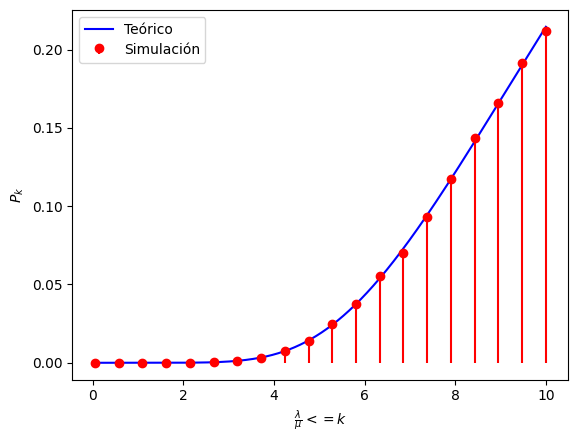

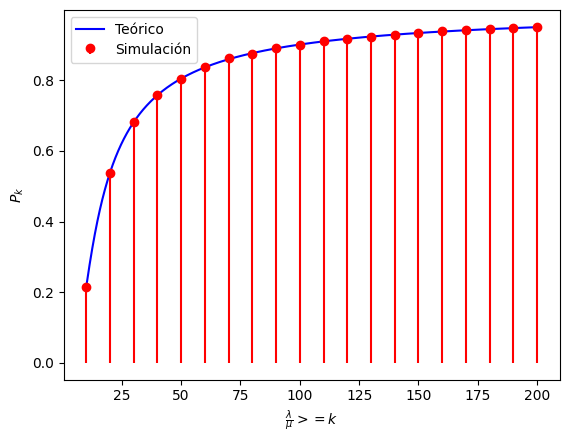

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
usuarios = 1000000
k = 10
simulaciones = 20
lambda_ = 8

# Resultado Teórico Probbilidad de bloqueo: Pk A<=k
A_menor = np.linspace(0.05, k, 10000)  # Cambiar el 0.95 por el A sugerido en clase
mu1 = lambda_ / A_menor
teorico_uno = bloqueo_erlang_b(k,lambda_,mu1)  # Usar el valor teórico según la cola asignada


# Resultado Teórico Probbilidad de bloqueo: Pk A>=k
A_mayor = np.linspace(k, k*20, 10000)  # Cambiar el 0.95 por el A sugerido en clase
mu2 = lambda_ / A_mayor
teorico_dos = bloqueo_erlang_b(k,lambda_,mu2)  # Usar el valor teórico según la cola asignada


#Simulaciones para A<=k
A_menor_simulacion = np.linspace(0.05, k, simulaciones)  # Cambiar el 0.95 por el A sugerido en clase
mu_simulacion_menor = lambda_ / A_menor_simulacion
resultadosimulacion_menor = np.zeros(simulaciones)
for n in range(simulaciones):
    total_clientes = 0
    clientes_bloqueados = 0
    tea = np.random.exponential(1 / lambda_, usuarios)
    tds = np.random.exponential(1 / mu_simulacion_menor[n], usuarios)
    env = simpy.Environment()
    servidor = simpy.Resource(env, capacity=10)# 10 servidores 
    env.process(generador_clientes(env, servidor, tea, tds))
    env.run(until=10000)
    resultadosimulacion_menor[n] = clientes_bloqueados / total_clientes

# Simulaciones para A>=k
A_mayor_simulacion = np.linspace(k, k*20, simulaciones)  # Cambiar el 0.95 por el A sugerido en clase
mu_simulacion_mayor = lambda_ / A_mayor_simulacion
resultadosimulacion_mayor = np.zeros(simulaciones)
for n in range(simulaciones):
    total_clientes = 0
    clientes_bloqueados = 0
    tea = np.random.exponential(1 / lambda_, usuarios)
    tds = np.random.exponential(1 / mu_simulacion_mayor[n], usuarios)
    env = simpy.Environment()
    servidor = simpy.Resource(env, capacity=k)# k servidores 
    env.process(generador_clientes(env, servidor, tea, tds))
    env.run(until=10000)
    resultadosimulacion_mayor[n] = clientes_bloqueados / total_clientes

# Graficar el resultado uno teórico_uno
plt.figure(1)
plt.plot(A_menor, teorico_uno, label='Teórico', color='b')
plt.xlabel(r'$\frac{\lambda}{\mu} <= k$')
plt.ylabel(r'$P_k$')
# simulacion uno
plt.stem(A_menor_simulacion, resultadosimulacion_menor, label='Simulación', basefmt=" ", linefmt='r-', markerfmt='ro')
plt.legend(loc='upper left')

# Graficar el resultado teórico_dos
plt.figure(2)
plt.plot(A_mayor, teorico_dos, label='Teórico', color='b')
plt.xlabel(r'$\frac{\lambda}{\mu} >= k$')
plt.ylabel(r'$P_k$')
# simulacion dos
plt.stem(A_mayor_simulacion, resultadosimulacion_mayor, label='Simulación',basefmt=" ", linefmt='r-', markerfmt='ro')
plt.legend(loc='upper left')

# Mostrar la gráfica
plt.show()


# Superfunción 🔰

In [22]:
def superfuncion(datos, nombre='aleatorio'):
    if datos is None or len(datos) == 0:
        print("Falta el vector de datos")
        return

    p = np.linspace(0, 1, 100000)
    datos = 1.0000000001 * np.array(datos).flatten()
    numero = np.quantile(datos, p)

    encabezado = f"def {nombre}(m, n):"
    cuerpo = f"    numero = {numero.tolist()}"
    final = (
        "    import numpy as np\n"
        "    if m == 1:\n"
        "        return np.transpose(np.random.choice(numero, (n,)))\n"
        "    else:\n"
        "        return np.random.choice(numero, (m, n))"
    )

    with open(f"{nombre}.py", "w") as f:
        f.write(encabezado + "\n")
        f.write(cuerpo + "\n")
        f.write(final + "\n")

    print(f"{nombre}.py generado. Revisa tu carpeta actual.")
    print(f"Luego puedes ejecutar: from {nombre} import {nombre}; {nombre}(m,n)")

# PdfCdfContinua

In [40]:
def pdfcdfcontinua(datos, minimo=None, maximo=None, particiones=None):
    """
    Estima la función de densidad (PDF) y la función de distribución acumulativa (CDF)
    de una muestra aleatoria `datos` usando histogramas.
    """

    datos = np.ravel(datos)
    total = len(datos)

    if minimo is None or maximo is None:
        rango = np.max(datos) - np.min(datos)
        minimo = np.min(datos) - 0.02 * rango
        maximo = np.max(datos) + 0.02 * rango

    print(minimo, maximo)

    if particiones is None:
        particiones = int(np.floor(np.sqrt(total)))

    bins = np.linspace(minimo, maximo, particiones + 1)

    # Histograma normalizado (densidad=True) para obtener PDF
    fr, edges = np.histogram(datos, bins=bins, density=False)
    ancho_bin = edges[1] - edges[0]
    pdf = fr / (total * ancho_bin)

    # CDF como suma acumulativa de las frecuencias normalizadas
    cdf = np.cumsum(fr) / total

    x = edges[:-1] + ancho_bin / 2  # Coordenadas del centro de cada bin

    # Gráficas
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))

    axs[0].plot(x, pdf, linewidth=2)
    axs[0].set_title("Estimación de la función de densidad")
    axs[0].set_xlabel("$x$")
    axs[0].set_ylabel("$f_X(x)$")
    axs[0].grid(True)

    axs[1].plot(x, cdf, linewidth=2)
    axs[1].set_title("Estimación de la Distribución Acumulativa")
    axs[1].set_xlabel("$x$")
    axs[1].set_ylabel("$F_X(x)$")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

Muestra de Agosto
[[1.34000000e-03 1.09000000e+03]
 [1.50800000e-03 1.74000000e+02]
 [4.17600000e-03 1.62000000e+02]
 ...
 [3.14281337e+03 1.74000000e+02]
 [3.14281754e+03 1.62000000e+02]
 [3.14282174e+03 1.74000000e+02]]
[0.000168 0.002668 0.003964 ... 0.004324 0.004176 0.004192]
0 0.01


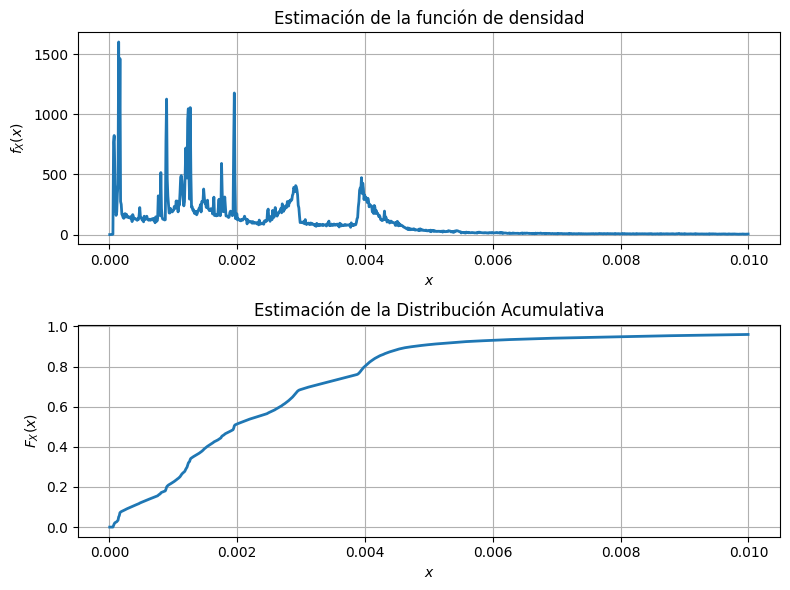

0 0.01


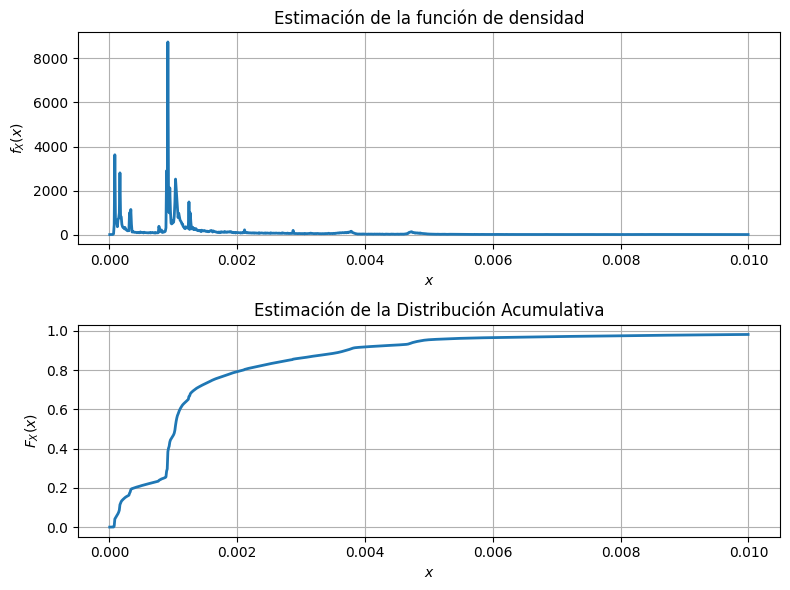

0 0.005


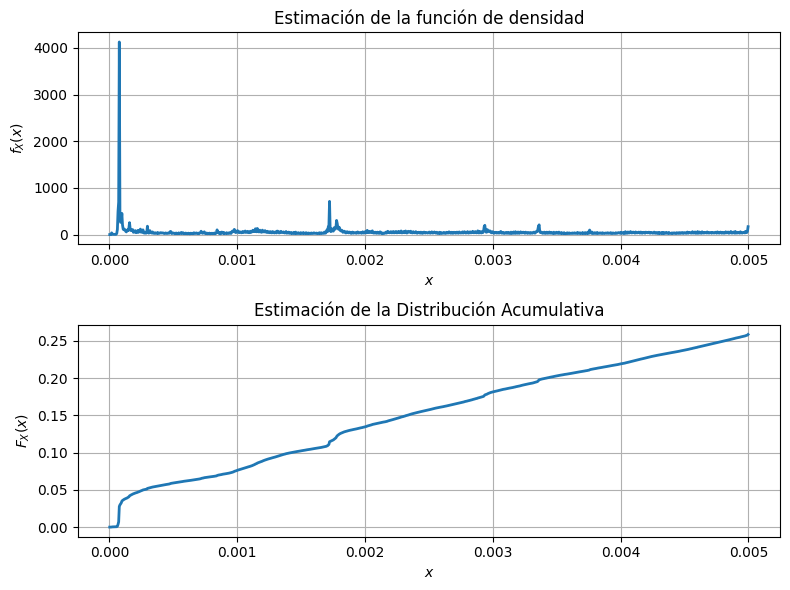

0 0.01


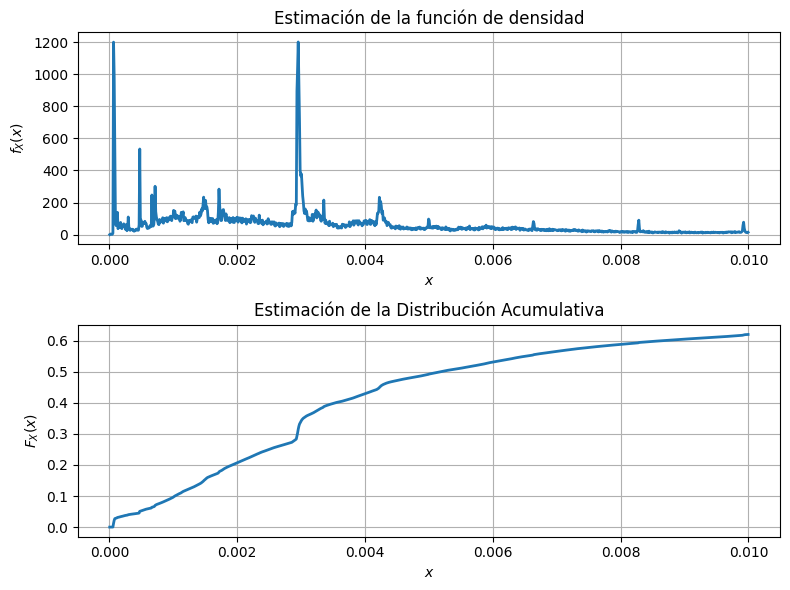

In [41]:

# BCpAug89
datosAug = np.loadtxt("./../BCpAug89.TL")
muestraAgosto = np.diff(datosAug[:, 0])

# BCpOct89
datosOct = np.loadtxt("./../BCpOct89.TL")
muestraOctubre = np.diff(datosOct[:, 0])

# BCOct89Ext
datosOctExt = np.loadtxt("./../BCOct89Ext.TL")
muestraOctubreExt = np.diff(datosOctExt[:, 0])

# BCOct89Ext4
datosOctExt4 = np.loadtxt("./../BCOct89Ext4.TL")
muestraOctubreExt4 = np.diff(datosOctExt4[:, 0])

print("Muestra de Agosto")
print(datosAug)
print(muestraAgosto)

pdfcdfcontinua(muestraAgosto, minimo=0, maximo=0.01, particiones=1000)
pdfcdfcontinua(muestraOctubre, minimo=0, maximo=0.01, particiones=1000)
pdfcdfcontinua(muestraOctubreExt, minimo=0, maximo=0.005, particiones=1000)
pdfcdfcontinua(muestraOctubreExt4, minimo=0, maximo=0.01, particiones=1000)

In [35]:
superfuncion(muestraAgosto, "agostoAleatorio")

superfuncion(muestraOctubre, "octubreAleatorio")

superfuncion(muestraOctubreExt, "octubreExtAleatorio")

superfuncion(muestraOctubreExt4, "octubreExt4Aleatorio")

agostoAleatorio.py generado. Revisa tu carpeta actual.
Luego puedes ejecutar: from agostoAleatorio import agostoAleatorio; agostoAleatorio(m,n)
octubreAleatorio.py generado. Revisa tu carpeta actual.
Luego puedes ejecutar: from octubreAleatorio import octubreAleatorio; octubreAleatorio(m,n)
octubreExtAleatorio.py generado. Revisa tu carpeta actual.
Luego puedes ejecutar: from octubreExtAleatorio import octubreExtAleatorio; octubreExtAleatorio(m,n)
octubreExt4Aleatorio.py generado. Revisa tu carpeta actual.
Luego puedes ejecutar: from octubreExt4Aleatorio import octubreExt4Aleatorio; octubreExt4Aleatorio(m,n)


In [ ]:
# import agostoAleatorio
# tea1 = agostoAleatorio.agostoAleatorio(1, 20)
# print("tea")
# print(tea1)

tea
[2.16000000e-03 8.68000000e-04 6.80000001e-05 1.82000000e-03
 2.88800000e-03 1.91600000e-03 3.88800000e-03 1.58800000e-03
 9.48000000e-04 9.08000000e-04 1.25200000e-03 4.02000000e-03
 2.42800000e-03 1.43600000e-03 1.97600000e-03 3.95600000e-03
 6.79999998e-05 9.72000000e-04 2.00000000e-03 1.18400000e-03]
